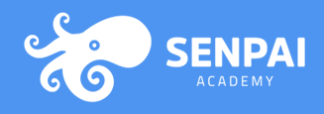

# Trabajo práctico final

**Curso**: Artificial Intelligence Developer 2 2020 Global

**Docente**: Agustin Sarasúa

**Título**: Multi-label classification

**Ingregrantes**: 
Lucas Canavesio -
Emiliano Herber 

**Fecha entrega**: 12-12-2020 








**Objetivo**: 
Se buscará aplicar  los contenidos aprendidos en el curso implementando una Multi-label Text Classification en fallos judiciales públicos de la Provincia de Entre Ríos - Argentina para lograr predecir las voces a las cuales aplica un determinado fallo.

En resumen dado un texto sugerir las voces que le corresponde.

Link data set: https://raw.githubusercontent.com/stjerdev/jurisprudencia/main/datosJurisprudencia.csv


## Descargando librerias

In [ ]:
import pandas as pd
import nltk, random
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_sp = set(stopwords.words('spanish'))
stemming = SnowballStemmer(language='spanish')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




## Leyendo y mostrando las primeras 5 filas del DataFrame

In [ ]:

# URL Data Set desde GitHub
url = 'https://raw.githubusercontent.com/stjerdev/jurisprudencia/main/datosJurisprudencia.csv'

# Leyendo y Mostrando las primeras 5 filas del DataFrame 
df = pd.read_csv(url)
df.head()
dataSet = df
dataSet.head()


,idsumario,memo,json_agg
0,5,"Prisión preventiva, Prórroga, Admisibilidad.\n...","[""Recurso de inaplicabilidad de ley"", ""Delitos..."
1,6,El beneficio de litigar sin gastos puede concl...,"[""Gastos del proceso. Beneficio de litigar sin..."
2,7,La apelante señala la falta de vigencia del cr...,"[""Accidentes de trabajo""]"
3,8,La obligación de entrega de certificación labo...,"[""Contrato de trabajo""]"
4,10,Cuando la parte contraria a quien ofrece la pr...,"[""Gastos del proceso. Honorarios"", ""Gastos del..."


## Limpiando dataset

In [ ]:
# Limpiando DataSet:
# Tokenize
# Quitando los caracteres que no son letras
# Stemming
# Stop_words 

stop_words = stopwords.words('spanish')
def clear_text(texto):
  tokens = nltk.tokenize.word_tokenize(texto,'spanish')
  tokens = [t for t in tokens if t.isalpha()]
  for t in range(len(tokens)):
    tokens[t] = stemming.stem(tokens[t])
  tokens=[t for t in tokens if t not in stop_words]
  cleanedText = " ".join(tokens)
  return cleanedText


In [ ]:
dataSet['memo'] = dataSet['memo'].apply(lambda x: clear_text(x))
dataSet['json_agg'] = dataSet['json_agg'].apply(lambda x: ast.literal_eval(x.lower()))
dataSet = dataSet.drop(['idsumario'], axis=1)

dataSet.head()

,memo,json_agg
0,prision prevent prorrog admisibil sd dres pero...,"[recurso de inaplicabilidad de ley, delitos co..."
1,benefici litig gast pued conclu caduc instanci...,[gastos del proceso. beneficio de litigar sin ...
2,apel señal falt vigenci criteri segu quo par r...,[accidentes de trabajo]
3,oblig entreg certif laboral nac cuand muer con...,[contrato de trabajo]
4,cuand part contrari qui ofrec prueb pericial m...,"[gastos del proceso. honorarios, gastos del pr..."


## Contando voces

In [ ]:
total_voces = sum(dataSet['json_agg'], [])
for i in range(0, len(total_voces)):
    total_voces[i] = total_voces[i].strip()
print(len(set(total_voces)))

338


In [ ]:
total_voces = nltk.FreqDist(total_voces)
total_voces_df = pd.DataFrame({'Voz': list(total_voces.keys()), 'Cantidad': list(total_voces.values())})

In [ ]:
# Cantidad de ocurrencias de un tipo de voz
total_voces_df.sort_values(by=['Cantidad'], ascending=False)

,Voz,Cantidad
6,contrato de trabajo,2353
5,accidentes de trabajo,1551
28,etapas del proceso. prueba,1402
38,daños y perjuicios,1347
0,recurso de inaplicabilidad de ley,1232
...,...,...
207,industria de la construcción,1
318,feriados,1
315,desechos peligrosos,1
107,libertad de prensa,1


## Grafico cantitad de apariciones de voces por textos

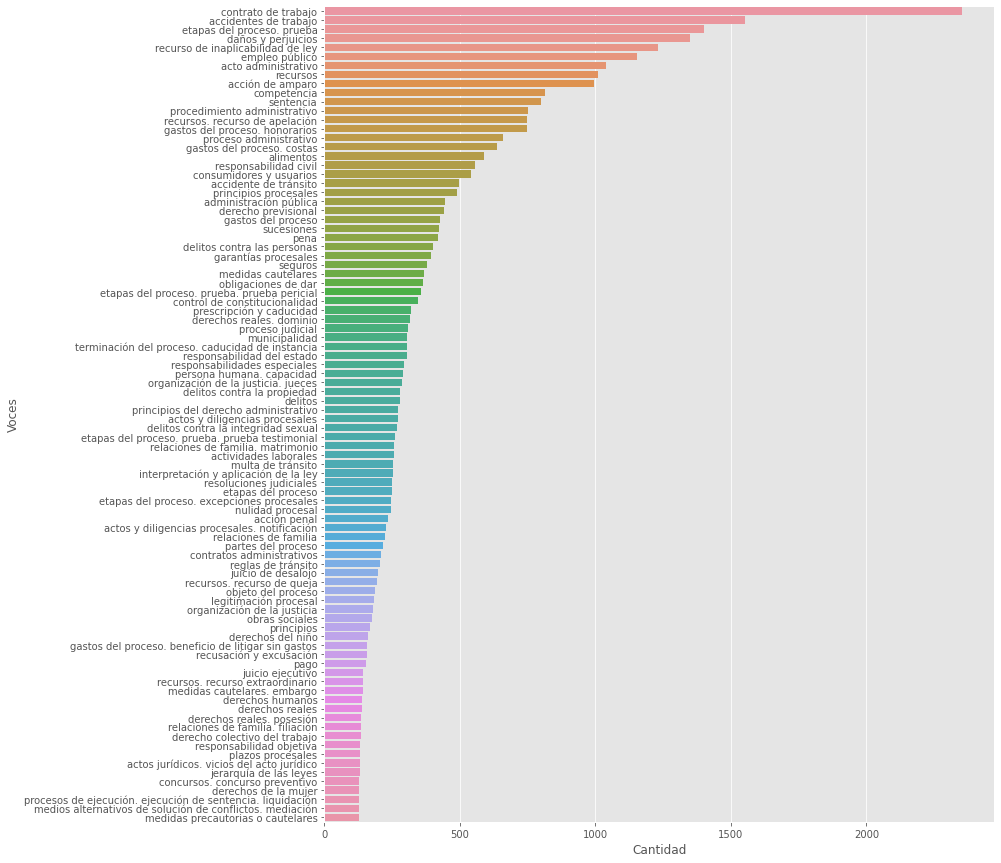

In [ ]:
plt.style.use('ggplot')
g = total_voces_df.nlargest(columns='Cantidad', n=90)
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x='Cantidad', y='Voz')
ax.set(ylabel='Voces')
plt.show()

## Creando Train DataSet y Test DataSet




In [ ]:
# Creando dataset and dataloader

train_size = 0.9
train_dataset=dataSet.sample(frac=train_size,random_state=200)
test_dataset=dataSet.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(dataSet.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (22375, 2)
TRAIN Dataset: (20138, 2)
TEST Dataset: (2237, 2)


In [ ]:
# MultiLabelBinarizer permite codificar varias etiquetas por instancia.

multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(train_dataset['json_agg'])
pd.DataFrame(y, columns=multilabel.classes_)

,accidente de tránsito,accidentes de trabajo,accidentes y enfermedades inculpables,acciones reales,acción de amparo,acción penal,actividad administrativa,actividad agropecuaria,actividad industrial,actividades laborales,acto administrativo,actos de comercio,actos jurídicos. causa,actos jurídicos. efectos,actos jurídicos. forma y prueba,actos jurídicos. nulidad del acto jurídico,actos jurídicos. objeto del acto jurídico,actos jurídicos. sujetos del acto jurídico,actos jurídicos. vicios del acto jurídico,actos voluntarios,actos voluntarios. vicios de la voluntad,actos y diligencias procesales,actos y diligencias procesales. audiencia,actos y diligencias procesales. notificación,actos y diligencias procesales. vistas y traslados,acumulación de acciones,administración pública,alimentos,asistencia médica,asistencia social\r\n,automotores,bien jurídico protegido,bienes,bioética,bloque constitucional,ciencias auxiliares del derecho penal,competencia,competencia. cuestiones de competencia,competencia. desplazamiento de la competencia,conciliación laboral,...,responsabilidades especiales,riesgo ambiental,régimen jubilatorio,salud pública,secuestro de bienes,seguros,sentencia,servicio postal,servicio público,servicio telefónico,servicios de comunicación audiovisual,sistema previsional,situaciones jurídicas subjetivas,sociedades comerciales,sociedades comerciales. sociedad anónima,sucesiones,sujetos de derecho,superior tribunal de justicia,suspensión de la ejecución de las decisiones administrativas,tecnología de la información (informático),telegrafía,tercerías,terminación del proceso,terminación del proceso. caducidad de instancia,terminación del proceso. desistimiento,terminación del proceso. transacción,transporte aéreo,transporte terrestre,tributario,turismo,títulos cambiarios. principios cambiarios,títulos de crédito,títulos de crédito. cheque,títulos de crédito. factura,títulos de crédito. pagaré,uniones convivenciales,universidades,vivienda\r\n,vivienda familiar,vivienda única
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20135,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20136,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# TfidfVectorizer: Convierte una colección de documentos sin procesar en una matriz de funciones TF-IDF
# TF-IDF: Es una medida estadística que evalúa qué tan relevante es una palabra para un documento en una colección de documentos
# analyzer -> Ngram a partir de palabras
# max_features -> Tamaño maximo de nuestro vocabulario
# ngram_range -> Límite inferior y superior del rango de valores n para los diferentes n-gramos que se van a extraer.
# encoding -> Codificación del texto.

tfidf = TfidfVectorizer(analyzer='word', max_features=6000, ngram_range=(1,3), encoding='latin-1')
X = tfidf.fit_transform(train_dataset['memo'])
X.shape, y.shape

((20138, 6000), (20138, 337))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [ ]:
# La similitud de Hamming y Jaccard se puede representar en términos de recuentos de verdadero | falso positivo | negativo.
def j_score(y_true, y_pred):
  jaccard = np.minimum(y_true, y_pred).sum(axis = 1)/np.maximum(y_true, y_pred).sum(axis = 1)
  return jaccard.mean()*100


def print_score(y_pred, clf):
  print("Clf: ", clf.__class__.__name__)
  print('Jacard score: {}'.format(j_score(y_test, y_pred)))
  print('----')

In [ ]:
# Linear Support Vector Classification. 
# Localhost n_jobs=8 utiliza 8 core del procesador - comentar en Colab

for classifier in [LinearSVC(C=6.0, penalty = 'l1', dual=False, max_iter=7600, class_weight="balanced")]:
  # clf = OneVsRestClassifier(classifier,n_jobs=8)
  clf = OneVsRestClassifier(classifier)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print_score(y_pred, classifier)

Clf:  LinearSVC
Jacard score: 40.44022614259468
----


## Prueba del modelo


In [ ]:
# Mostrando voz original
test_dataset['json_agg'][10]

['acto administrativo', 'competencia']

In [ ]:
# Prueba del modelo
# Insertando texto al modelo para la prueba
x = [test_dataset['memo'][10]]

xt = tfidf.transform(x)
clf.predict(xt)

multilabel.inverse_transform(clf.predict(xt))

[('acto administrativo', 'proceso administrativo')]

## Conclusión 

 

*   La predicción del modelo es baja por lo cual en la mayoría de los casos no cumple con los requisitos.
*   Intentamos adaptarlo a una red neuronal pero no tuvimos éxito por lo cuál optamos por entregar el primer trabajo armado.

 

